In [102]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
import re 
import string
import gensim

## Data Loading and Understanding

In [45]:
data = pd.read_csv("IMDBDataset.csv")[:5000]

In [46]:
data.columns = ['review_body_text', 'sentiment']

In [47]:
data.head()

,review_body_text,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [48]:
data.columns

Index(['review_body_text', 'sentiment'], dtype='object')

In [49]:
reviews_sentiment_count = data['sentiment'].value_counts()
reviews_sentiment_count

sentiment
negative    2532
positive    2468
Name: count, dtype: int64

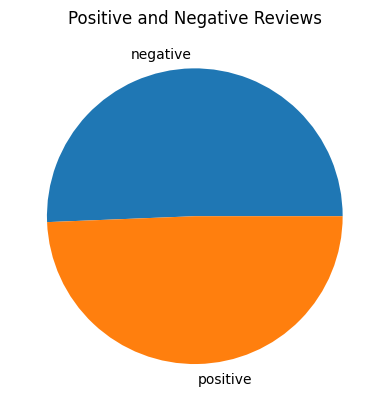

In [50]:

plt.pie(reviews_sentiment_count, labels = reviews_sentiment_count.index)
plt.title('Positive and Negative Reviews')
plt.ylabel('')
plt.show()


### This shows positive and negative review are 50-50 %

## Step 2 : Text preprocessing

### 1.Removing html text using Beautifulsoup

- As there are various html tags in our review body text.so, removing it using beautiful soup

In [29]:
from bs4 import BeautifulSoup

data['review_body_text'] = data['review_body_text'].apply(
             lambda review_body_text: BeautifulSoup(review_body_text, "html.parser").get_text()
    )

C:\Users\nirma\AppData\Local\Temp\ipykernel_9264\994431550.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda review_body_text: BeautifulSoup(review_body_text, "html.parser").get_text()


In [104]:
ps = nltk.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

#This converts to lower case , remove punctuation , special char and stemming 
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

data['cleaned_review_text'] = data['review_body_text'].apply(lambda text:clean_text(text))

data.head()


,review_body_text,sentiment,cleaned_review_text
0,One of the other reviewers has mentioned that ...,positive,"[one, review, mention, watch, 1, oz, episod, y..."
1,A wonderful little production. <br /><br />The...,positive,"[wonder, littl, product, br, br, film, techniq..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonder, way, spend, time, hot, summe..."
3,Basically there's a family where a little boy ...,negative,"[basic, there, famili, littl, boy, jake, think..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, mattei, love, time, money, visual, st..."


## Vectorize

### Vectorizing the review using TF-IDF method

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=clean_text, preprocessor=None, lowercase=False, token_pattern=None)

tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_review_text'])


In [96]:
# tfidf_array = tfidf_matrix.toarray()#makes easier intrepretation 
# features_terms = tfidf_vectorizer.get_feature_names_out()
# print(features_terms)
# tfidf_df = pd.DataFrame(tfidf_array, columns=features_terms)
# tfidf_df.head()

### Vectorizing the review using Word2Vec method

In [ ]:
# copying to 
# data['tokenized_review'] = data['cleaned_review_text'] 

# Training word2vector mode
word2vec_model = gensim.models.Word2Vec(sentences=data['cleaned_review_text'], vector_size=100, window=5, min_count=2, workers=4)

def vectorize_review(review, model):
    vectors = [model.wv[word] for word in review if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

word2vec_matrix = np.array(data['cleaned_review_text'].apply(lambda x: vectorize_review(x, word2vec_model)))



In [110]:
# Convert to DataFrame for visualization
word2vec_df = pd.DataFrame(word2vec_matrix)
word2vec_df.head()

,0
0,"[-0.2938954, 0.2036074, 0.19308577, 0.00613791..."
1,"[-0.17773284, 0.21858706, 0.0886419, -0.020055..."
2,"[-0.30249014, 0.14439514, 0.16566433, 0.013978..."
3,"[-0.3510144, 0.19952066, 0.2137157, 0.09595357..."
4,"[-0.26507497, 0.24153164, 0.15330966, -0.01559..."


## for practice only(body_length and punc%)

In [55]:
def count_punct(text):
    punct_count = [char for char in text if char in string.punctuation]
    sum_of_punct = len(punct_count)
    return sum_of_punct/(len(text) - text.count(" ")) * 200 



data['body_length'] = data['body_text'].apply(lambda text:len(text) - text.count(" "))
data['punct_percent'] = data['body_text'].apply(lambda text:count_punct(text))

KeyError: 'body_text'

In [ ]:
data.head()

,body_text,review,body_text_nostop,body_text_stemmed,body_length,punct_percent
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y...",1425,8.421053
1,A wonderful little production. The filming tec...,positive,"[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass...",807,6.443618
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe...",741,7.557355
3,Basically there's a family where a little boy ...,negative,"[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think...",581,8.261618
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st...",1048,6.106870
